## Section 1. Introduction ##

In this notebook, the dataset to be processed is the Labor Force Survey conducted April 2016 and retrieved through Philippine Statistics Authority database. 



In [76]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_rel
%matplotlib inline


plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Importing LFS PUF April 2016.CSV</h1>

In [77]:
try:
    lfs_data = pd.read_csv("src/data/LFS PUF April 2016.CSV")
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    exit()

<h1>Data Information, Pre-Processing, and Cleaning</h1>

Let's get an overview of our dataset.

In [78]:
lfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180862 entries, 0 to 180861
Data columns (total 50 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PUFREG           180862 non-null  int64  
 1   PUFPRV           180862 non-null  int64  
 2   PUFPRRCD         180862 non-null  int64  
 3   PUFHHNUM         180862 non-null  int64  
 4   PUFURB2K10       180862 non-null  int64  
 5   PUFPWGTFIN       180862 non-null  float64
 6   PUFSVYMO         180862 non-null  int64  
 7   PUFSVYYR         180862 non-null  int64  
 8   PUFPSU           180862 non-null  int64  
 9   PUFRPL           180862 non-null  int64  
 10  PUFHHSIZE        180862 non-null  int64  
 11  PUFC01_LNO       180862 non-null  int64  
 12  PUFC03_REL       180862 non-null  int64  
 13  PUFC04_SEX       180862 non-null  int64  
 14  PUFC05_AGE       180862 non-null  int64  
 15  PUFC06_MSTAT     180862 non-null  object 
 16  PUFC07_GRADE     180862 non-null  obje

---
Of interest to us, there are:
<ul><li>1 contains float values, </li>
<li>14 contain integer values, and </li>
<li><b>35 are object values</b>.</li></ul>


---
Let's check for duplicates:

In [79]:
lfs_data.duplicated().sum()

np.int64(0)

No duplicates here, and therefore no cleaning need follow in this regard.

The dataset seems to contain null values in the form of whitespaces. Let's count those:

In [80]:
has_null = lfs_data.apply(lambda col: col.str.isspace().sum() if col.dtype == 'object' else 0)

print("Number Empty Cells:")
print(has_null[has_null > 0])

Number Empty Cells:
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK       178569
PUFC32_JOBSM       178569
PUFC33_WEEKS       178569
PUFC34_WYNOT       134985
PUFC35_LTLOOKW     179269
PUFC36_AVAIL       174893
PUFC37_WILLING     174893
PUFC38_PREVJOB     132692
PUFC40_POCC        152982
PUFC41_WQTR         81627
PUFC43_QKB         107825
PUFNEWEMPSTAT       61337
dtype: int64


---
And standardize, replacing these whitespace values with -1:

In [81]:
lfs_data.replace(r"^\s+$", -1, regex=True, inplace=True)
nan_counts_per_column = lfs_data.isna().sum()
print(nan_counts_per_column[nan_counts_per_column > 0])

Series([], dtype: int64)


Now that these are -1, let's return to the data types, and find if our object columns from earlier are convertible to integers (or float):

In [82]:
int_convertible_columns = []

for col in lfs_data.columns:
    if lfs_data[col].dtypes == 'object':  
        try:
            float_vals = lfs_data[col].dropna().astype(float)
            if (float_vals % 1 == 0).all():
                int_convertible_columns.append(col)
        except ValueError:
            pass 

print("Safely convertable to int:")
print(int_convertible_columns)

Safely convertable to int:
['PUFC06_MSTAT', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC10_CONWR', 'PUFC11_WORK', 'PUFC12_JOB', 'PUFC14_PROCC', 'PUFC16_PKB', 'PUFC17_NATEM', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC20_PWMORE', 'PUFC21_PLADDW', 'PUFC22_PFWRK', 'PUFC23_PCLASS', 'PUFC24_PBASIS', 'PUFC25_PBASIC', 'PUFC26_OJOB', 'PUFC27_NJOBS', 'PUFC28_THOURS', 'PUFC29_WWM48H', 'PUFC30_LOOKW', 'PUFC31_FLWRK', 'PUFC32_JOBSM', 'PUFC33_WEEKS', 'PUFC34_WYNOT', 'PUFC35_LTLOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFC38_PREVJOB', 'PUFC40_POCC', 'PUFC41_WQTR', 'PUFC43_QKB', 'PUFNEWEMPSTAT']


---
And convert to int

In [83]:
columns_to_convert = [
    'PUFC06_MSTAT', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC10_CONWR', 'PUFC11_WORK', 
    'PUFC12_JOB', 'PUFC14_PROCC', 'PUFC16_PKB', 'PUFC17_NATEM', 'PUFC18_PNWHRS', 
    'PUFC19_PHOURS', 'PUFC20_PWMORE', 'PUFC21_PLADDW', 'PUFC22_PFWRK', 'PUFC23_PCLASS', 
    'PUFC24_PBASIS', 'PUFC25_PBASIC', 'PUFC26_OJOB', 'PUFC27_NJOBS', 'PUFC28_THOURS', 
    'PUFC29_WWM48H', 'PUFC30_LOOKW', 'PUFC31_FLWRK', 'PUFC32_JOBSM', 'PUFC33_WEEKS', 
    'PUFC34_WYNOT', 'PUFC35_LTLOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFC38_PREVJOB', 
    'PUFC40_POCC', 'PUFC41_WQTR', 'PUFC43_QKB', 'PUFNEWEMPSTAT'
]

for col in columns_to_convert:
    lfs_data[col] = lfs_data[col].astype(int) 

---
Let's also apply the unique() function to our dataset.

In [84]:
lfs_data.apply(lambda x: x.nunique())

PUFREG                17
PUFPRV                86
PUFPRRCD             116
PUFHHNUM           40880
PUFURB2K10             2
PUFPWGTFIN         35599
PUFSVYMO               1
PUFSVYYR               1
PUFPSU               975
PUFRPL                 4
PUFHHSIZE             20
PUFC01_LNO            23
PUFC03_REL            11
PUFC04_SEX             2
PUFC05_AGE           100
PUFC06_MSTAT           7
PUFC07_GRADE          68
PUFC08_CURSCH          3
PUFC09_GRADTECH        3
PUFC10_CONWR           6
PUFC11_WORK            3
PUFC12_JOB             3
PUFC14_PROCC          44
PUFC16_PKB            88
PUFC17_NATEM           4
PUFC18_PNWHRS         17
PUFC19_PHOURS        103
PUFC20_PWMORE          3
PUFC21_PLADDW          3
PUFC22_PFWRK           3
PUFC23_PCLASS          8
PUFC24_PBASIS          9
PUFC25_PBASIC       1152
PUFC26_OJOB            3
PUFC27_NJOBS           6
PUFC28_THOURS        111
PUFC29_WWM48H          6
PUFC30_LOOKW           3
PUFC31_FLWRK           3
PUFC32_JOBSM           7


---
Considering our dataset has 18,000 entries, features with particularly low numbers stand out as questions that have clear, defined choices. Reviewing the [questionnaire](https://psada.psa.gov.ph/catalog/67/download/537), we find that certain questions ask the participant to specify beyond prespecified choices.

This column possibly contains "010," which is obviously not an integer. We ensure this column is a string, and check for values not specified in the questionnaire.

In [85]:
lfs_data['PUFC07_GRADE'] = lfs_data['PUFC07_GRADE']
valid_codes = [
    0, 10,  # No Grade, Preschool
    210, 220, 230, 240, 250, 260, 280,  # Elementary
    310, 320, 330, 340, 350,  # High School
    410, 420,  # Post Secondary; If Graduate Specify
    810, 820, 830, 840,  # College; If Graduate Specify
    900,  # Post Baccalaureate
    np.nan
]
invalid_rows = lfs_data[~(lfs_data['PUFC07_GRADE'].isin(valid_codes))]

unique_invalid_values = invalid_rows['PUFC07_GRADE'].unique()
print(unique_invalid_values)

['350' '320' '250' -1 '622' '672' '240' '220' '614' '330' '010' '280'
 '632' '310' '000' '900' '820' '230' '589' '572' '210' '830' '810' '634'
 '686' '581' '681' '552' '534' '840' '658' '548' '648' '652' '662' '601'
 '642' '562' '260' '685' '631' '684' '340' '584' '621' '410' '420' '664'
 '676' '521' '638' '554' '646' '689' '522' '654' '644' '532' '531' '514'
 '558' '501' '586' '542' '576' '544' '585' '564']


Values 5XX 6XX are not detailed in the questionnaire. As it instructs the participant to specify whether they graduated from post secondary or college, we'll create a new data point to encapsulate these.

In [86]:
lfs_data.loc[~lfs_data['PUFC07_GRADE'].isin(valid_codes), 'PUFC07_GRADE'] = 700
print(lfs_data['PUFC07_GRADE'].unique())

[700]


In [87]:
lfs_data['PUFC11_WORK'].value_counts()

PUFC11_WORK
 2    87556
 1    71412
-1    21894
Name: count, dtype: int64

## EDA

In [88]:
lfs_data_with_nan = lfs_data.copy()
lfs_data_with_nan.replace(-1, np.nan, inplace=True)
corr_matrix = lfs_data_with_nan.corr()

strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)): 
        corr_value = corr_matrix.iloc[i, j]
        if (0.5 < corr_value < 1) or (-1 < corr_value < -0.5):
            strong_correlations.append((
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_value
            ))

strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

print("Strong correlations (|corr| > 0.5 and |corr| < 1):")
for var1, var2, corr in strong_correlations:
    print(f"{var1} — {var2}: {corr:.3f}")


Strong correlations (|corr| > 0.5 and |corr| < 1):
PUFPRV — PUFPRRCD: 1.000
PUFREG — PUFHHNUM: 0.995
PUFC19_PHOURS — PUFC28_THOURS: 0.972
PUFC16_PKB — PUFC43_QKB: 0.969
PUFC11_WORK — PUFNEWEMPSTAT: 0.964
PUFC41_WQTR — PUFNEWEMPSTAT: 0.878
PUFC11_WORK — PUFC41_WQTR: 0.852
PUFC31_FLWRK — PUFC38_PREVJOB: -0.795
PUFC36_AVAIL — PUFC37_WILLING: 0.785
PUFC37_WILLING — PUFNEWEMPSTAT: 0.785
PUFC18_PNWHRS — PUFC19_PHOURS: 0.785
PUFC18_PNWHRS — PUFC28_THOURS: 0.769
PUFPWGTFIN — PUFPSU: 0.709
PUFC12_JOB — PUFNEWEMPSTAT: 0.704
PUFC05_AGE — PUFC06_MSTAT: 0.701
PUFC34_WYNOT — PUFNEWEMPSTAT: 0.631
PUFC30_LOOKW — PUFNEWEMPSTAT: 0.625
PUFC01_LNO — PUFC03_REL: 0.625
PUFC05_AGE — PUFC08_CURSCH: 0.590
PUFHHSIZE — PUFC01_LNO: 0.571
PUFC01_LNO — PUFC05_AGE: -0.567
PUFC20_PWMORE — PUFC21_PLADDW: 0.556
PUFC08_CURSCH — PUFC11_WORK: -0.514
PUFC08_CURSCH — PUFC34_WYNOT: -0.510
PUFC08_CURSCH — PUFNEWEMPSTAT: -0.509


We will use feature_cols as our predictor variables for PUFC11_WORK. Using Regression, we will evaluate how well we can predict whether or not someone has worked in the past week. We begin with preprocessing.

### Logistic Regression (LR)
Because this is a classification task, we can choose Logistic Regression as a baseline and a first model. In theory, PUFC11_WORK is a binary classification task, something that Logistic Regression should excel at. Since this uses a sigmoid function to map linear probabilities, between 0 and 1, making this suitable for determining whether someone "worked" (1) or "did not work" (0) within the past week. Finally, LR is particularly interpetable considering the task we're doing, allowing us to check the significance and coefficients associated with each predictor variable if need be.

#### Preprocessing: LR
We create a copy of our target variable PUFC11_WORK, and create five 80-20 train-test splits for the non-empty PUFC11 data we have. We'll also perform one-hot encoding, given our feature columns are all categorical. We also map the values of PUFC11, normally [1,2], to [0,1]. In addition, because we've determined that our feature_cols are intentionally unanswered as appropriate, we will be treating these values as empty rather than imputing.

In [89]:
from src.preprocessing import prepare_data_kfold

target_col = 'PUFC11_WORK'
feature_cols = [
    'PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 
    'PUFC07_GRADE', 'PUFC08_CURSCH', 
    'PUFC38_PREVJOB', 'PUFC31_FLWRK',
    'PUFC30_LOOKW', 'PUFC34_WYNOT'
]

categorical_cols = feature_cols
n_splits = 5
missing_value =-1
seed = 45

folds_data = prepare_data_kfold(lfs_data, target_col = target_col,
                         n_splits = n_splits,
                         missing_value = missing_value,
                         categorical_cols = categorical_cols,
                         feature_cols = feature_cols,
                         seed = seed)

Preparing data for k-fold cross-validation...
Training on 127174 samples with 9 features
Testing on 31794 samples
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']
Training on 127174 samples with 9 features
Testing on 31794 samples
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']
Training on 127174 samples with 9 features
Testing on 31794 samples
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']
Training on 127175 samples with 9 features
Testing on 31793 samples
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']
Training on 127175 samples with 9 features
Testing on 31793 sample

#### Training: LR
We are ready to start training. As we are setting a baseline, we'll start off with these hyperparameters. We'll use Stochastic Gradient Descent as our specified optimizer, though technically implementing mini-batch with a batch size of 128. We are looking for improvements in loss greater than 0.0001, else we stop early within three epochs. Lastly, we use a weight_decay of 0, indicating no regularization for now. All hyperparameters indicated below also indicate their default value if unspecified. For each convergence, we will track the metrics of that fold and aggregate it across all folds.


==================== FOLD 1 ====================
Epoch 1/50: Train Loss: 0.2033, Test Loss: 0.1086, Train Acc: 0.9550, Test Acc: 0.9817, LR: 0.010000
Epoch 2/50: Train Loss: 0.0949, Test Loss: 0.0863, Train Acc: 0.9846, Test Acc: 0.9857, LR: 0.010000
Epoch 3/50: Train Loss: 0.0818, Test Loss: 0.0789, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.010000
Epoch 4/50: Train Loss: 0.0765, Test Loss: 0.0752, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.010000
Epoch 5/50: Train Loss: 0.0736, Test Loss: 0.0731, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.005000
Epoch 6/50: Train Loss: 0.0721, Test Loss: 0.0723, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.005000
Epoch 7/50: Train Loss: 0.0714, Test Loss: 0.0717, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.005000
Epoch 8/50: Train Loss: 0.0708, Test Loss: 0.0712, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.005000
Epoch 9/50: Train Loss: 0.0702, Test Loss: 0.0707, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.005000
Epoch 10/50: Train Loss: 0.0698, Test Los

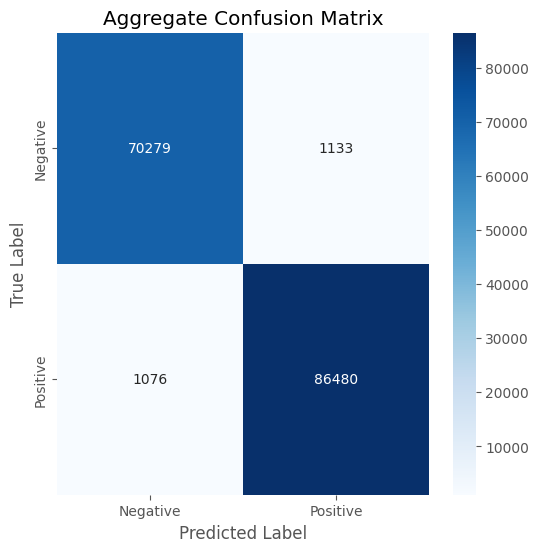

In [90]:
from src.trainEval import *
result_dict = train_model(
    folds_data,
    optimizer_string="sgd", #Stochastic Gradient Descent
    scheduler_step_size=5,
    learning_rate=0.01,
    scheduler_gamma=0.5,
    convergence_threshold=1e-4, 
    num_epochs=50,
    patience=3, # Stop at 3 epochs with no improvement
    weight_decay=0,
    seed=seed
)

lr_accuracies_test = result_dict["all_final_test_accuracies"]
print(lr_accuracies_test);


print("\nModel training complete!")
aggregate_cm = result_dict["aggregate_confusion_matrix"]

sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"]) 


print(f"  Average Final Train Loss:     {result_dict['aggregated_final_metrics']['avg_final_train_loss']:.6f}")
print(f"  Average Final Test Loss:      {result_dict['aggregated_final_metrics']['avg_final_test_loss']:.6f}")
print(f"  Average Final Train Accuracy: {result_dict['aggregated_final_metrics']['avg_final_train_accuracy']:.6f}")
print(f"  Average Final Test Accuracy:  {result_dict['aggregated_final_metrics']['avg_final_test_accuracy']:.6f}")

plt.title("Aggregate Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Error: LR
This model performed well for an initial run. All folds ran for 25 epochs. Both accuracies for test and train data are high, though there is usually minimal improvement from the third epoch onwards. The train and test loss both see steady improvement, but we see the test loss  to be slightly higher and plateau earlier at around the sixteenth epoch. 

We see that the train loss is slightly lower than the test loss in folds 1, 2, and 5, while the reverse is true for folds 3 and 4. This would indicate a model that overfits for the former folds, and underfits for the latter. Averaging these out, its clear that with an aggregated train and test loss of 0.684 and 0.687 respectively, the overall performance of the model doesn't significantly overfit nor underfit. This outcome is surprising, considering that we've used nine predictor variables while also forgoing the use of regularization, as these would have been expected to introduce noise and contribute to overfitting through curse of dimensionality.

#### Hyperparameter Tuning: LR

With our base parameters having been set, we can begin hyperparameter tuning. We'll implement *Random Search* as to not have to exhaustively branch through each possible combination of parameters. Below are the hyperparameter's we'll use and choose from. For example, if our algorithm randomly, for instance, chooses the second element of each, then it will test Logistic Regression at a learning rate of 0.1, batch size of 64, and the with the ADAM optimizer, etc. 

Values evenly spaced between 0.000001 and 0.001 will be explored for the learning rates. This will go on for fifty iterations, afterwhich a best model will be selected based on test accuracy. We'll perform random search rather than grid search, as a compromise to searching through all 259,200 combinations of hyperparameters in our grid.

In [91]:
param_distributions = {
    'learning_rate': np.logspace(-4, -1, 20),
    'batch_size': [32, 64, 128, 256],
    'optimizer': ['sgd', 'adam', 'rmsprop'],
    'weight_decay': np.logspace(-5, -2, 10),
    'num_epochs': [30, 50, 75, 100],
    'scheduler_step_size': [5, 10, 15],
    'scheduler_gamma': [0.5, 0.7, 0.9],
    'patience': [3, 5, 7]
}

hyperparameter_results = hyperparameter_random_search(folds_data=folds_data, param_distributions=param_distributions, n_iter_search=50) 


Testing configuration:
{'weight_decay': np.float64(0.00046415888336127773), 'scheduler_step_size': 5, 'scheduler_gamma': 0.9, 'patience': 5, 'optimizer': 'sgd', 'num_epochs': 30, 'learning_rate': np.float64(0.06951927961775606), 'batch_size': 256}

==================== FOLD 1 ====================
Epoch 1/30: Train Loss: 0.1207, Test Loss: 0.0773, Train Acc: 0.9766, Test Acc: 0.9857, LR: 0.069519
Epoch 2/30: Train Loss: 0.0729, Test Loss: 0.0712, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.069519
Epoch 3/30: Train Loss: 0.0692, Test Loss: 0.0693, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.069519
Epoch 4/30: Train Loss: 0.0678, Test Loss: 0.0684, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.069519
Epoch 5/30: Train Loss: 0.0670, Test Loss: 0.0679, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.062567
Epoch 6/30: Train Loss: 0.0665, Test Loss: 0.0677, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.062567
Epoch 7/30: Train Loss: 0.0662, Test Loss: 0.0674, Train Acc: 0.9862, Test Acc: 0.9857, LR: 0.0

KeyboardInterrupt: 

# HPT Interpretation

In [ ]:
##best_params = hyperparameter_results['best_params']
##results_summary = hyperparameter_results['summary_df']

## Decision Tree (DT)

Another machine learning model we can use is the decision tree. Decision trees don't necessarily assume a linear relationship between our predictor variables and PUFC11, which could be benificial for finding complex relationships. Rather, they recursively partition our data with rules. Further, while it can get quite complex as it scales, individual nodes are also uncomplicated in how they are interpreted, which is also helpful for understanding the factors that determine whether an individual has worked within the past week.

#### Training: DT
We can recycle the one-hot encoded data we used in preparation for Logistic Regression and immediately use it for training our decision tree.

In [95]:
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import numpy as np

accuracies_train = []
losses_train = []
dt_accuracies_test = []
losses_test = []
confusion_matrices = [] 

for i in range(5):
    X_train, X_test, y_train, y_test = (
        folds_data[i]['X_train'],
        folds_data[i]['X_test'],
        folds_data[i]['y_train'],
        folds_data[i]['y_test'],
    )

    model = DecisionTreeClassifier(random_state=45, min_impurity_decrease=0.001)

    model.fit(X_train, y_train)

    # Train predictions and loss
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    loss_train = log_loss(y_train, y_train_pred_proba)

    # Test predictions and loss
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    loss_test = log_loss(y_test, y_test_pred_proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices.append(cm)

    accuracies_train.append(accuracy_train)
    losses_train.append(loss_train)
    dt_accuracies_test.append(accuracy_test)
    losses_test.append(loss_test)

    print(f"Fold {i+1} - Train Accuracy: {accuracy_train:.4f}, Train Loss: {loss_train:.4f}, Test Accuracy: {accuracy_test:.4f}, Test Loss: {loss_test:.4f}")
    print(f"Fold {i+1} - Confusion Matrix:\n{cm}\n")

avg_accuracy_train = np.mean(accuracies_train)
avg_loss_train = np.mean(losses_train)
avg_accuracy_test = np.mean(dt_accuracies_test)
avg_loss_test = np.mean(losses_test)

print(f"\nAggregated Metrics:")
print(f"Average Train Accuracy: {avg_accuracy_train:.4f}")
print(f"Average Train Loss: {avg_loss_train:.4f}")
print(f"Average Test Accuracy: {avg_accuracy_test:.4f}")
print(f"Average Test Loss: {avg_loss_test:.4f}")

print("\nOverall Confusion Matrix:")
print(sum(confusion_matrices))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Fold 1 - Train Accuracy: 0.9852, Train Loss: 0.0702, Test Accuracy: 0.9847, Test Loss: 0.0724
Fold 1 - Confusion Matrix:
[[14020   282]
 [  206 17286]]

Fold 2 - Train Accuracy: 0.9851, Train Loss: 0.0703, Test Accuracy: 0.9849, Test Loss: 0.0712
Fold 2 - Confusion Matrix:
[[13926   260]
 [  219 17389]]

Fold 3 - Train Accuracy: 0.9850, Train Loss: 0.0706, Test Accuracy: 0.9854, Test Loss: 0.0747
Fold 3 - Confusion Matrix:
[[14106   243]
 [  222 17223]]

Fold 4 - Train Accuracy: 0.9850, Train Loss: 0.0708, Test Accuracy: 0.9855, Test Loss: 0.0727
Fold 4 - Confusion Matrix:
[[13951   262]
 [  200 17380]]

Fold 5 - Train Accuracy: 0.9851, Train Loss: 0.0702, Test Accuracy: 0.9850, Test Loss: 0.0724
Fold 5 - Confusion Matrix:
[[14113   249]
 [  228 17203]]


Aggregated Metrics:
Average Train Accuracy: 0.9851
Average Train Loss: 0.0704
Average Test Accuracy: 0.9851
Average Test Loss: 0.0727

Overall Confusion Matrix:
[[70116  1296]
 [ 1075 86481]]

Classification Report:
              prec

#### Error: DT
Our model is also performing well, and with each confusion metric no less than 0.98. As this is a decision tree, a model usually prone to overfitting, we do see minimal overfitting, seeing as our train loss is higher than our test loss by 0.0023, though this is arguably a negligible gap.



#### Hyperparameter Tuning: DT

Similar to our methodology with Logistic Regression, we will implement random search for our tuning as a compromise to exhaustively searching through each hyperparameter combination. This time, we will explicitly define certain thresholds and measures. 

Our previous two hyperparameters, max_depth and minimum_impurity_decrease, will now range fom 30-60 and 0.001 to 0.1 respectively, adding variability to our parameters despite minimal signs of overfitting. We will allow the min_samples_leaf to enforce generalization or allow leaf nodes with one sample. 

Of note, we will add cost-complexity pruning as a form of regularizaton for our decision trees. We will also be exploring both gini and entropy as criteria, as the former minimizes chances of misclassification while the latter measures information gain.

#### Error: DT
Our model is also performing well, and with each confusion metric no less than 0.98. As this is a decision tree, a model usually prone to overfitting, we do see minimal overfitting, seeing as our train loss is higher than our test loss by 0.0023, though this is arguably a negligible gap.



In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, log_loss

p_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [30, 45, 50, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "min_impurity_decrease": [0.001, 0.005, 0.01], ## pre-pruning
    "ccp_alpha": np.logspace(-4, 0, 10) ## post-pruning
}

best_params_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
losses = []

for i in range(5):
    X_train, X_test, y_train, y_test = (
        folds_data[i]['X_train'],
        folds_data[i]['X_test'],
        folds_data[i]['y_train'],
        folds_data[i]['y_test'],
    )

    model = DecisionTreeClassifier(random_state=45)

    random_search = RandomizedSearchCV(
        model, p_grid, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, random_state=45
    )
    random_search.fit(X_train, y_train)

    best_params_list.append(random_search.best_params_)

    accuracies.append(accuracy_score(y_test, random_search.best_estimator_.predict(X_test)))
    report = classification_report(y_test, random_search.best_estimator_.predict(X_test), output_dict=True, zero_division=0)
    losses.append(log_loss(y_test, random_search.best_estimator_.predict_proba(X_test)))
    precisions.append(report['macro avg']['precision'])
    recalls.append(report['macro avg']['recall'])
    f1_scores.append(report['macro avg']['f1-score'])

    print(f"Fold {i+1} - Best Parameters: {random_search.best_params_}")
    print(f"Fold {i+1} - Accuracy: {accuracies[-1]:.4f}, Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1-score: {f1_scores[-1]:.4f}, Loss: {losses[-1]:.4f}")


avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_loss = np.mean(losses)

print(f"\nAggregated Metrics:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print("\nBest Parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")


best_fold_index = np.argmax(accuracies)
best_fold_params = best_params_list[best_fold_index]
print("\nBest Performing Fold Parameters:", best_fold_params)


best_model = DecisionTreeClassifier(random_state=45, **best_fold_params)


all_X_train = np.concatenate([folds_data[i]['X_train'] for i in range(5)])
all_y_train = np.concatenate([folds_data[i]['y_train'] for i in range(5)])

best_model.fit(all_X_train, all_y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 1 - Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_depth': 50, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.0001)}
Fold 1 - Accuracy: 0.9857, Precision: 0.9856, Recall: 0.9854, F1-score: 0.9855, Loss: 0.0689
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 2 - Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_depth': 50, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.0001)}
Fold 2 - Accuracy: 0.9860, Precision: 0.9859, Recall: 0.9858, F1-score: 0.9858, Loss: 0.0673
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 3 - Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_depth': 50, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.0001)}
Fold 3 - Accuracy: 0.9863, Precision: 0.9861, Recall: 0.9861, F1-score: 0.9861, Loss: 0.

KeyboardInterrupt: 

In [96]:
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

train_preds = best_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

train_probs = best_model.predict_proba(X_train)
test_probs = best_model.predict_proba(X_test)
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)

cm = confusion_matrix(y_test, test_preds)  
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")


plt.show()

print(cm)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Training Log Loss: {train_loss:.4f}")
print(f"Test Log Loss: {test_loss:.4f}")


train_precision = precision_score(y_train, train_preds, zero_division=0)
test_precision = precision_score(y_test, test_preds, zero_division=0)

train_recall = recall_score(y_train, train_preds, zero_division=0)
test_recall = recall_score(y_test, test_preds, zero_division=0)

train_f1 = f1_score(y_train, train_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)

print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")

print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")

print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

C:\Users\Devon Javier\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 135 features, but DecisionTreeClassifier is expecting 160 features as input.

kNN


In [97]:


#initial k value, optimal value will be determined later
k = 5

accuracies_train = []
losses_train = []
knn_accuracies_test = []
losses_test = []
confusion_matrices = [] 

for i, fold in enumerate(folds_data):
    print(f"fold {i+1}")

    X_train = fold['X_train']
    y_train = fold['y_train']
    X_test = fold['X_test']
    y_test = fold['y_test']

    knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)

    y_train_pred = knn_model.predict(X_train)
    y_train_pred_proba = knn_model.predict_proba(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    loss_train = log_loss(y_train, y_train_pred_proba)

    y_test_pred = knn_model.predict(X_test)
    y_test_pred_proba = knn_model.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    loss_test = log_loss(y_test, y_test_pred_proba)

    cm = confusion_matrix(y_test, y_test_pred)


    accuracies_train.append(accuracy_train)
    losses_train.append(loss_train)
    knn_accuracies_test.append(accuracy_test)
    losses_test.append(loss_test)

    ## perf metrics
    print(f"Fold {i+1} - Train Accuracy: {accuracy_train:.4f}, Train Loss: {loss_train:.4f}, Test Accuracy: {accuracy_test:.4f}, Test Loss: {loss_test:.4f}")
    print(f"Fold {i+1} - Confusion Matrix:\n{cm}\n")



fold 1
Fold 1 - Train Accuracy: 0.9862, Train Loss: 0.4597, Test Accuracy: 0.9855, Test Loss: 0.4779
Fold 1 - Confusion Matrix:
[[14051   251]
 [  209 17283]]

fold 2
Fold 2 - Train Accuracy: 0.9854, Train Loss: 0.4657, Test Accuracy: 0.9848, Test Loss: 0.4808
Fold 2 - Confusion Matrix:
[[13962   224]
 [  260 17348]]

fold 3
Fold 3 - Train Accuracy: 0.9860, Train Loss: 0.4627, Test Accuracy: 0.9863, Test Loss: 0.4518
Fold 3 - Confusion Matrix:
[[14142   207]
 [  228 17217]]

fold 4
Fold 4 - Train Accuracy: 0.9853, Train Loss: 0.4610, Test Accuracy: 0.9854, Test Loss: 0.4617
Fold 4 - Confusion Matrix:
[[13986   227]
 [  236 17344]]

fold 5
Fold 5 - Train Accuracy: 0.9862, Train Loss: 0.4574, Test Accuracy: 0.9855, Test Loss: 0.4924
Fold 5 - Confusion Matrix:
[[14135   227]
 [  233 17198]]



Find Optimal K value (hpt)

In [98]:
param_grid = {'n_neighbors': range(1, 31)} 

grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("best k:", grid_search.best_params_['n_neighbors'])


best k: 5


In [ ]:
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)
knn_acc = accuracy_score(y_test, y_pred)
print("acc: ", knn_acc)

[[14135   227]
 [  233 17198]]
acc:  0.9855314062844023


Statistical Testing

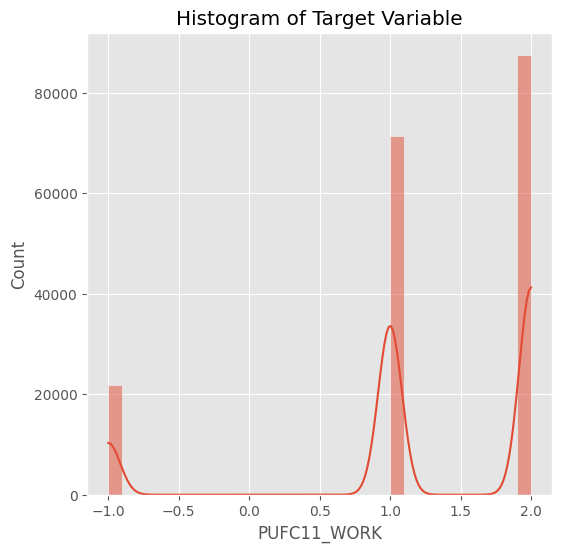

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(lfs_data[target_col], bins=30, kde=True)
plt.title("Histogram of Target Variable")
plt.show()


In [ ]:
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
import scikit_posthocs as sp

print(" LR Accuracies:", lr_accuracies_test)
print(" DT Accuracies:", dt_accuracies_test)
print(" KNN Accuracies:", knn_accuracies_test)

dt_accuracies_test = np.array(dt_accuracies_test)
knn_accuracies_test = np.array(knn_accuracies_test) 
rf_accuracies_test = np.array(lr_accuracies_test) 

data = np.vstack((lr_accuracies_test, dt_accuracies_test, knn_accuracies_test)).T

f_stat, p_value = friedmanchisquare(lr_accuracies_test, dt_accuracies_test, knn_accuracies_test)
print("Friedman Test: Chi-square statistic =", f_stat, ", p-value =", p_value)


## idk what im doing
alpha = 0.05
if p_value < alpha:
    print("\nSignificant difference detected! Running McNemar’s test...\n")


    lr_preds = np.array([1, 1, 0, 1, 1])  
    dt_preds = np.array([1, 1, 1, 0, 1])  
    knn_preds = np.array([0, 1, 1, 1, 1])  

    def run_mcnemar(model1, model2, name1, name2):
        """Runs McNemar's test between two classifiers."""
        table = np.zeros((2, 2))
        for i in range(len(model1)):
            table[model1[i], model2[i]] += 1  

        result = mcnemar(table, exact=True)
        print(f"{name1} vs {name2}: McNemar's p-value = {result.pvalue}")

        if result.pvalue < 0.05:
            print(f"Significant difference between {name1} and {name2}!\n")
        else:
            print(f"No significant difference between {name1} and {name2}.\n")

    run_mcnemar(lr_preds, dt_preds, "LR", "DT")
    run_mcnemar(lr_preds, knn_preds, "LR", "KNN")
    run_mcnemar(dt_preds, knn_preds, "DT", "KNN")

else:
    print("\nNo significant difference detected. McNemar's test is unnecessary.")

 LR Accuracies: [0.985657671258728, 0.986003648487136, 0.9866012455180223, 0.9865379171515742, 0.985720127071997]
 DT Accuracies: [0.98465119 0.98493426 0.9853746  0.9854685  0.9849967 ]
 KNN Accuracies: [0.98553186 0.984777   0.98631817 0.98543705 0.98553141]
Friedman Test: Chi-square statistic = 7.6000000000000085 , p-value = 0.0223707718561655

Significant difference detected! Running McNemar’s test...

LR vs DT: McNemar's p-value = 1.0
No significant difference between LR and DT.

LR vs KNN: McNemar's p-value = 1.0
No significant difference between LR and KNN.

DT vs KNN: McNemar's p-value = 1.0
No significant difference between DT and KNN.

